In [1]:
pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/50.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/50.8 MB 1.9 MB/s eta 0:00:27
   ---------------------------------------- 0.1/50.8 MB 1.1 MB/s eta 0:00:45
   ---------------------------------------- 0.1/50.8 MB 1.2 MB/s eta 0:00:42
   ---------------------------------------- 0.3/50.8 MB 1.6 MB/s eta 0:00:33
   ---------------------------------------- 0.3/50.8 MB 1.6 MB/s eta 0:00:32
   ---------------------------------------- 0.5/50.8 MB 2.0 MB/s eta 0:00:25
   ---------------------------------------- 0.6/50.8 MB 1.9 MB/s eta 0:00:27
    --------------------------------------- 0.7/50.8 MB 2.1 MB/s eta 0:00:25
    --------------------------------------- 1.0/50.8 MB 2.5 MB/s eta 0:00:21
    --------------------------------------- 1.1/50.8 MB 2.4 MB/s eta 0:00:21
    -----

In [6]:
import cv2
import mediapipe as mp
import csv

# Initialize the holistic model
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Load the video
video_path = './Dataset/001-nm-01-090(trimmed).mp4'
cap = cv2.VideoCapture(video_path)

# Get video details
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the path for the output CSV file
output_csv_path = './HPE_Outputs/keypoints.csv'

# Output CSV file
csv_file = open(output_csv_path, 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['frame_number', 'landmark', 'x', 'y', 'z'])

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video_path = './HPE_Outputs/output_video.mp4'
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB for mediapipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with the holistic model
    results = holistic.process(frame_rgb)

    # Extract keypoints
    if results.pose_landmarks:
        for i, landmark in enumerate(results.pose_landmarks.landmark):
            csv_writer.writerow([cap.get(cv2.CAP_PROP_POS_FRAMES), f'pose_{i}', landmark.x, landmark.y, landmark.z])

    if results.left_hand_landmarks:
        for i, landmark in enumerate(results.left_hand_landmarks.landmark):
            csv_writer.writerow([cap.get(cv2.CAP_PROP_POS_FRAMES), f'left_{i}', landmark.x, landmark.y, landmark.z])

    if results.right_hand_landmarks:
        for i, landmark in enumerate(results.right_hand_landmarks.landmark):
            csv_writer.writerow([cap.get(cv2.CAP_PROP_POS_FRAMES), f'right_{i}', landmark.x, landmark.y, landmark.z])

    # Draw the keypoints on the frame
    mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp.solutions.drawing_utils.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp.solutions.drawing_utils.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

    # Write the frame with landmarks into the output video
    out.write(frame)

    # Display the frame
    cv2.imshow('Center of Mass',frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the windows
cap.release()
out.release()
cv2.destroyAllWindows()
csv_file.close()

print("CSV file is saved in:", output_csv_path)
print("Output video is saved in:", output_video_path)


CSV file is saved in: ./HPE_Outputs/keypoints.csv
Output video is saved in: ./HPE_Outputs/output_video.mp4


In [16]:
import pandas as pd
import numpy as np

# Load data into a DataFrame
data = pd.read_csv("./HPE_Outputs/keypoints.csv")

# Define a function to calculate angle between three points
def calculate_angle(p1, p2, p3):
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    return np.degrees(angle)

# Calculate Stride Length
data['stride_length'] = np.sqrt((data['x'].shift(-2) - data['x'])**2 + (data['y'].shift(-2) - data['y'])**2 + (data['z'].shift(-2) - data['z'])**2)

# 25 frames per second, calculate cadence
frames_per_second = 25
data_per_minute = data.shape[0] / (frames_per_second * 60)
data['cadence'] = data_per_minute / 2  # assuming each step involves both feet

# Calculate knee angle
# Assuming the joints for the knee are landmarks 25, 27, and 29
data['knee_angle'] = data.apply(lambda row: calculate_angle(
    [row['x'], row['y'], row['z']],
    [data.iloc[row.name + 1]['x'], data.iloc[row.name + 1]['y'], data.iloc[row.name + 1]['z']],
    [data.iloc[row.name + 2]['x'], data.iloc[row.name + 2]['y'], data.iloc[row.name + 2]['z']]
) if row.name < len(data) - 2 else np.nan, axis=1)

# Print or visualize the extracted features
print(data[['frame_number', 'stride_length', 'cadence', 'knee_angle']])

# Export the DataFrame to a new CSV file
data.to_csv("./HPE_Outputs/modified_data.csv", index=False)


      frame_number  stride_length  cadence  knee_angle
0              9.0       0.025571    0.678  117.417294
1              9.0       0.003682    0.678  177.261444
2              9.0       0.031339    0.678   79.905216
3              9.0       0.031496    0.678   82.115001
4              9.0       0.001993    0.678  175.702483
...            ...            ...      ...         ...
2029          69.0       0.018354    0.678    5.440831
2030          69.0       0.082063    0.678    8.897712
2031          69.0       0.068048    0.678    7.273023
2032          69.0            NaN    0.678         NaN
2033          69.0            NaN    0.678         NaN

[2034 rows x 4 columns]


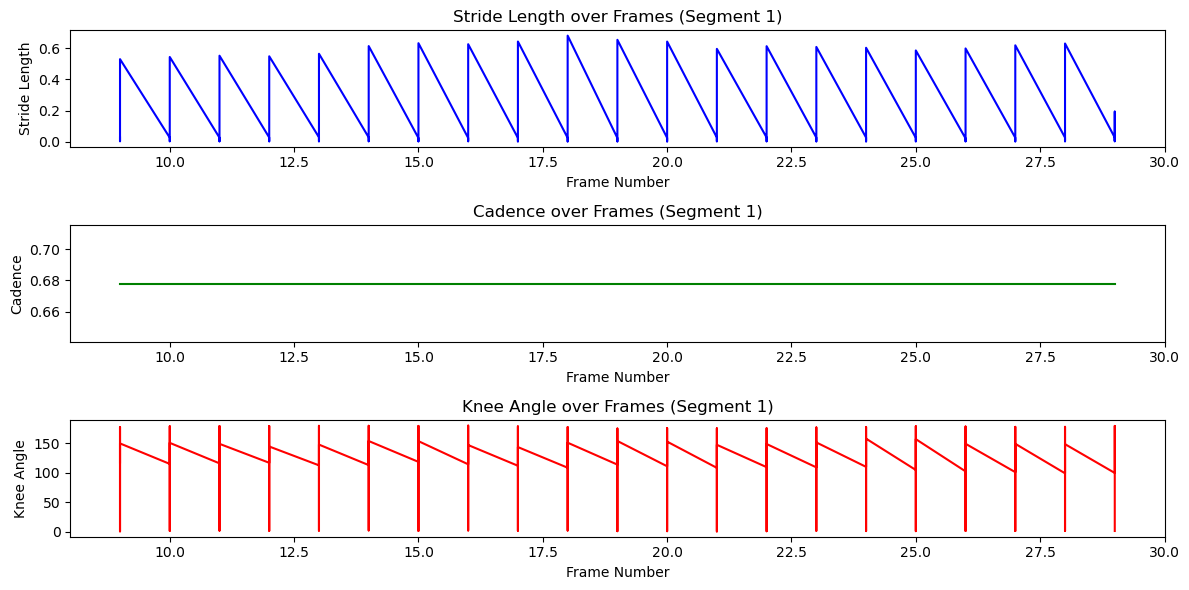

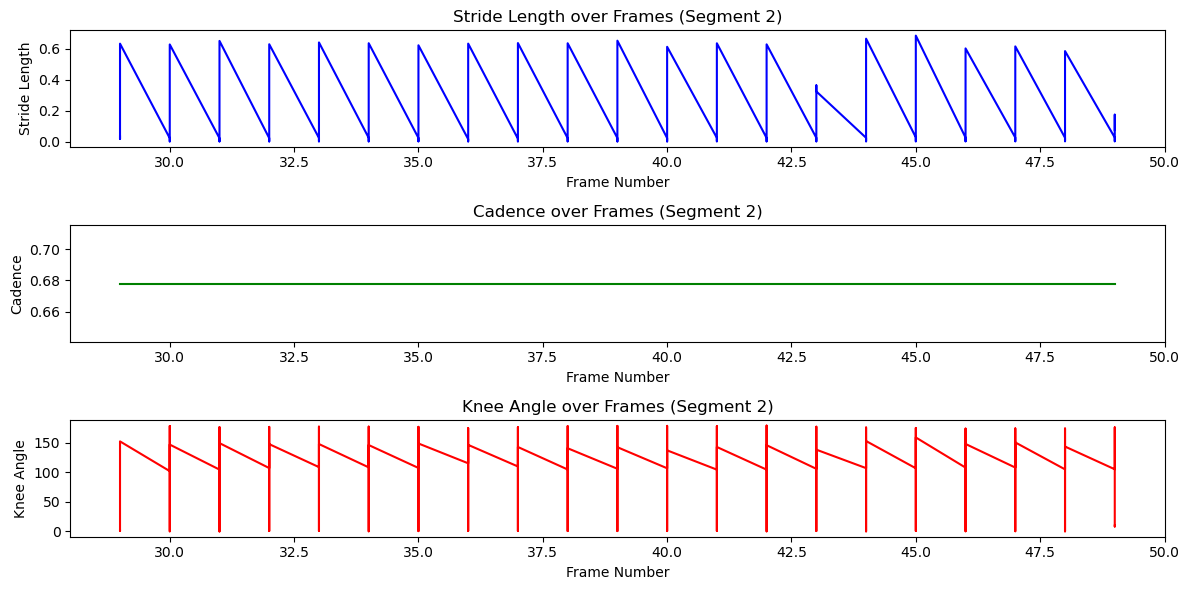

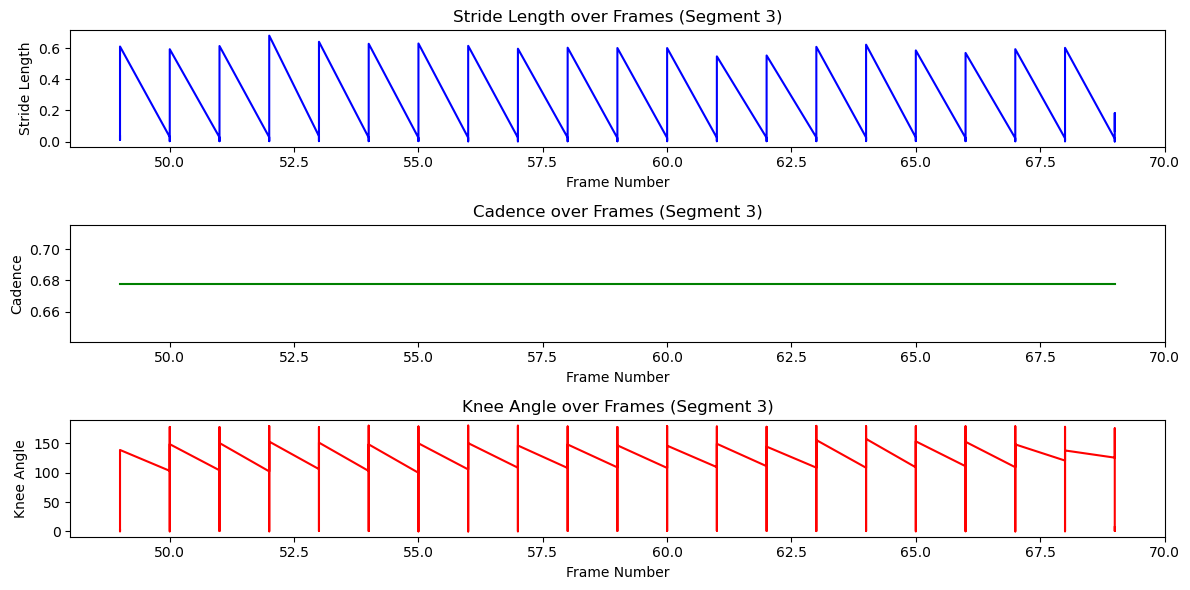

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Load modified data
modified_data = pd.read_csv("./HPE_Outputs/modified_data.csv")

# Split data into segments (assuming 3 segments for this example)
num_segments = 5
segment_length = len(modified_data) // num_segments

# Plotting
for i in range(num_segments):
    start_index = i * segment_length
    end_index = (i + 1) * segment_length if i < num_segments - 1 else len(modified_data)
    
    segment_data = modified_data.iloc[start_index:end_index]
    
    plt.figure(figsize=(12, 6))

    # Plot stride length
    plt.subplot(3, 1, 1)
    plt.plot(segment_data['frame_number'], segment_data['stride_length'], color='blue')
    plt.title('Stride Length over Frames (Segment {})'.format(i+1))
    plt.xlabel('Frame Number')
    plt.ylabel('Stride Length')

    # Plot cadence
    plt.subplot(3, 1, 2)
    plt.plot(segment_data['frame_number'], segment_data['cadence'], color='green')
    plt.title('Cadence over Frames (Segment {})'.format(i+1))
    plt.xlabel('Frame Number')
    plt.ylabel('Cadence')

    # Plot knee angle
    plt.subplot(3, 1, 3)
    plt.plot(segment_data['frame_number'], segment_data['knee_angle'], color='red')
    plt.title('Knee Angle over Frames (Segment {})'.format(i+1))
    plt.xlabel('Frame Number')
    plt.ylabel('Knee Angle')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()
